In [1]:
import requests
from pathlib import Path
from typing import Union
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np

from sklearn.linear_model import LogisticRegression

In [ ]:
DATASET_URL = ('https://firebasestorage.googleapis.com/v0/b/hackeps-2019.appspot.com/o/noised-MNIST.npz?alt=media&token=4cee641b-9e31-42c4-b9c8-e771d2eecbad')

In [3]:
def download_file(url: str, 
                  file_path: Union[str, Path]):
  r = requests.get(DATASET_URL, allow_redirects=True)
  Path(file_path).open('wb').write(r.content)

In [4]:
fname = 'noised-MNIST.npz'
download_file(DATASET_URL, fname)

data = np.load(fname)
x, y, x_submission = data.values()

model = LogisticRegression(multi_class='auto',solver='saga',max_iter=5000)

model.fit(x,y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33, random_state=42)

test_pred = model.predict(x_test)

y_pred = model.predict(x_submission)

f = open("submission.txt","w")

for y in y_pred:
  f.write(str(y) + "\n")

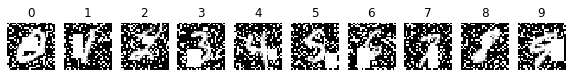

In [6]:
cols = 10
rows = 1
plt.figure(figsize=(10, 10))
for l in range(10): # Digits from 0 to 9
  plt.subplot(rows, cols, l + 1)
  l_digits = noised_x[y == l]
  idx = np.random.randint(0, high=l_digits.shape[0], size=1)
  
  im = l_digits[idx]
  im = im.astype(np.float32) / 255.
  im = im.reshape(28, 28)
  
  plt.title(l)
  plt.imshow(im, cmap='gray')
  plt.axis('off')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33)

In [8]:
np.savez_compressed('noised-MNIST.npz', x=x_train, y=y_train, x_submission=x_test)
np.savez_compressed('noised-MNIST-secret.npz', x=x_test, y=y_test)

In [9]:
#@title Training code
class ImageScaler(BaseEstimator, TransformerMixin):

  def __init__(self, scale_factor):
    self.scale_factor = scale_factor

  def fit(self, x, y=None):
    return self
  
  def transform(self, x):
    x = x.astype(np.float64)
    x = x / float(self.scale_factor)
    x = np.clip(x, 0, 1.)
    return x

preprocessing_pipeline = Pipeline([('scale', ImageScaler(255)), 
                                   ('standardize', StandardScaler())])

x_train_prep = preprocessing_pipeline.fit_transform(x_train)
rnd_forest = RandomForestClassifier(n_estimators=20, max_depth=10)
rnd_forest.fit(x_train_prep, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
y_pred = rnd_forest.predict(preprocessing_pipeline.transform(x_test))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      2222
           1       0.78      0.91      0.84      2647
           2       0.79      0.71      0.75      2325
           3       0.74      0.68      0.71      2318
           4       0.75      0.75      0.75      2225
           5       0.80      0.54      0.64      2120
           6       0.75      0.82      0.79      2220
           7       0.78      0.74      0.76      2361
           8       0.66      0.66      0.66      2332
           9       0.61      0.75      0.68      2330

    accuracy                           0.74     23100
   macro avg       0.75      0.74      0.74     23100
weighted avg       0.75      0.74      0.74     23100



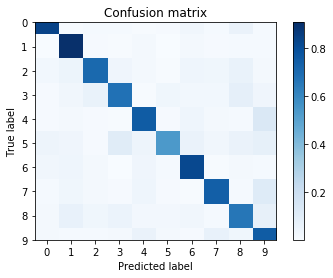

In [11]:
def plot_confusion_matrix(y_true, y_pred,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)
plt.show()